<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/BITCOIN_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import python modules 

In [ ]:
from sklearn.model_selection import train_test_split   
from sklearn import ensemble              
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
!pip install scikit-misc
!pip install pdpbox

# 데이터: Bitcoin Returns (2016.1.1~2021.3.31)
- 수익률로 변환

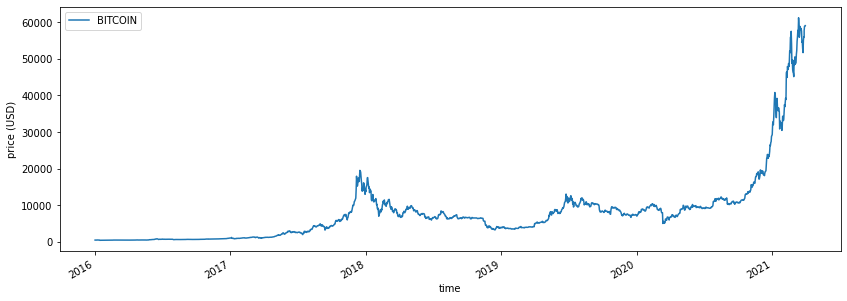

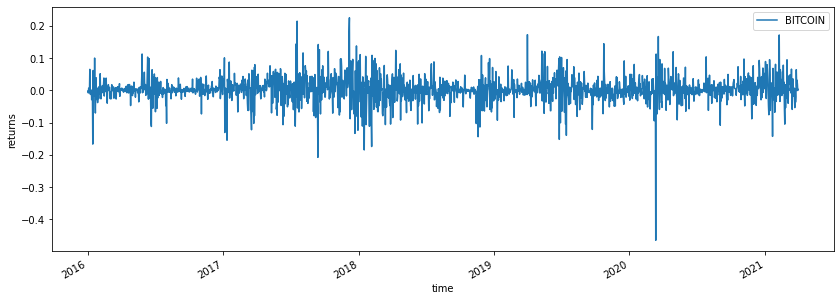

In [56]:
import pandas_datareader as pdr
import datetime

df_null = pdr.get_data_yahoo(['BTC-USD'], 
                          start=datetime.datetime(2016, 1, 1), 
                          end=datetime.datetime(2021, 3, 31))['Close']

df1 = df_null.dropna()
df1["ROR"] = np.log(df1["BTC-USD"]).diff()
df1 = df1.dropna()
df1.head()

Y1=df1.ROR

fig, ax = plt.subplots(figsize=(14, 5))
df1.plot(y="BTC-USD", label='BITCOIN', ax=ax)
ax.set(xlabel='time', ylabel='price (USD)')
ax.legend();

fig, ax = plt.subplots(figsize=(14, 5))
df1.plot(y="ROR", label='BITCOIN', ax=ax)
ax.set(xlabel='time', ylabel='returns')
ax.legend();


# Dependent Variable

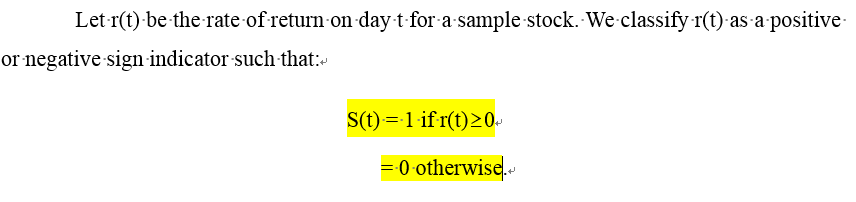

In [70]:
T=len(Y1)
move2=-1*(Y1<0)  ## two states 
y=move2[1:].dropna()+1   
x=move2[0:T-1].dropna()+1
df=pd.DataFrame(y)
df.columns=['state(t)']
df["state(t-1)"]=x.values 
df

,state(t),state(t-1)
Date,,
2016-01-03,0,0
2016-01-04,1,0
2016-01-05,0,1
2016-01-06,0,0
2016-01-07,1,0
...,...,...
2021-03-28,0,1
2021-03-28,1,0
2021-03-29,1,1


# Building block
- We begin with a time varying Markov process
E[S_t  |  S_t-1, {Z_t-1}], 
- where {Z_t-1} is the conditioning variables we can observe or construct at t-1. 

# Model 1
- Z_t-1 = [R_t-1, ..., R_t-10], 최근 10일동안의 수익률

In [71]:
lag1= Y1.shift(1); lag2= Y1.shift(2); lag3= Y1.shift(3) ; lag4= Y1.shift(4); lag5= Y1.shift(5)
lag6= Y1.shift(6); lag7= Y1.shift(7); lag8= Y1.shift(8) ; lag9= Y1.shift(9); lag10= Y1.shift(10)
X=pd.DataFrame(lag1[1:])
X.columns=['lag1']
X['lag2']=lag2[1:]; X['lag3']=lag3[1:]; X['lag4']=lag4[1:]; X['lag5']=lag5[1:]; X['lag6']=lag6[1:]
X['lag7']=lag7[1:]; X['lag8']=lag8[1:]; X['lag9']=lag9[1:]; X['lag10']=lag10[1:]
X['state(t-1)']=df['state(t-1)']
X['state(t)']=df['state(t)']
X=X.dropna()
X

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,state(t-1),state(t)
Date,,,,,,,,,,,,
2016-01-12,0.000975,0.000849,-0.012475,-0.010574,0.065272,-0.006631,-0.002615,0.007137,-0.007938,-0.002065,1,0
2016-01-13,-0.028817,0.000975,0.000849,-0.012475,-0.010574,0.065272,-0.006631,-0.002615,0.007137,-0.007938,0,0
2016-01-14,-0.007647,-0.028817,0.000975,0.000849,-0.012475,-0.010574,0.065272,-0.006631,-0.002615,0.007137,0,0
2016-01-15,-0.004787,-0.007647,-0.028817,0.000975,0.000849,-0.012475,-0.010574,0.065272,-0.006631,-0.002615,0,0
2016-01-16,-0.166434,-0.004787,-0.007647,-0.028817,0.000975,0.000849,-0.012475,-0.010574,0.065272,-0.006631,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-28,0.015052,0.064288,-0.020485,-0.036552,0.003840,-0.053457,-0.013644,-0.000566,0.008394,-0.017339,1,0
2021-03-28,-0.000407,0.015052,0.064288,-0.020485,-0.036552,0.003840,-0.053457,-0.013644,-0.000566,0.008394,0,1
2021-03-29,0.031655,-0.000407,0.015052,0.064288,-0.020485,-0.036552,0.003840,-0.053457,-0.013644,-0.000566,1,1


In [72]:
y=X["state(t)"]
del X["state(t)"]
y_train=y[0:1450]  ## train set 비율 = 약 76%
y_test=y[1450:]
X_train=X[0:1450]
X_test=X[1450:]

In [96]:
X_train

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,state(t-1)
Date,,,,,,,,,,,
2016-01-12,0.000975,0.000849,-0.012475,-0.010574,0.065272,-0.006631,-0.002615,0.007137,-0.007938,-0.002065,1
2016-01-13,-0.028817,0.000975,0.000849,-0.012475,-0.010574,0.065272,-0.006631,-0.002615,0.007137,-0.007938,0
2016-01-14,-0.007647,-0.028817,0.000975,0.000849,-0.012475,-0.010574,0.065272,-0.006631,-0.002615,0.007137,0
2016-01-15,-0.004787,-0.007647,-0.028817,0.000975,0.000849,-0.012475,-0.010574,0.065272,-0.006631,-0.002615,0
2016-01-16,-0.166434,-0.004787,-0.007647,-0.028817,0.000975,0.000849,-0.012475,-0.010574,0.065272,-0.006631,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,-0.004987,-0.006491,-0.004510,-0.020981,0.043595,-0.003839,0.002215,-0.010216,0.091502,-0.043028,0
2019-12-28,0.007037,-0.004987,-0.006491,-0.004510,-0.020981,0.043595,-0.003839,0.002215,-0.010216,0.091502,1
2019-12-29,0.003820,0.007037,-0.004987,-0.006491,-0.004510,-0.020981,0.043595,-0.003839,0.002215,-0.010216,1


In [89]:
seed=1851   
xNames = np.array(list(X_train))

params = {'n_estimators': 400,           ##  optimized hyper parameters for the model
          'learning_rate': 0.025}         

m = ensemble.GradientBoostingClassifier(**params,random_state=seed)
m.fit(X_train, y_train)
acc1=round(m.score(X_test, y_test),3)
acc2=round(m.score(X_train, y_train),3)
print('in-sample prediction accuracy=', acc2)
print('out-of-sample prediction accuracy=', acc1)

in-sample prediction accuracy= 0.814
out-of-sample prediction accuracy= 0.563


# Over-fitting 발생
- complexity가 높은 ML 모형에서 빈번하게 발생함
- 회귀분석과 달리, 설명변수가 많다고 예측력이 높아지는 것이 아니다.
- Adding new features is not always beneficial, because you increase the dimension of your search space and thus make the problem harder to be optimized.

# Feature Engineering
- 설명변수를 더 줄이면서 accruracy를 올릴 수 없을까?
- 과거 수익률의 함수로 예측력을 높여주는 새로운 covariates를 찾아라!


# Model 2: 
- Z_t = exponential moving average of Bitcoin returns,
- We try to find two EMA's that maximizes the prediction performance.

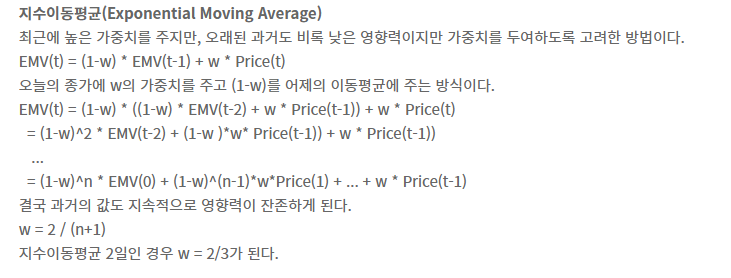

In [90]:
x3 =Y1.ewm(3).mean()    # 3-day EMA
x10=Y1.ewm(10).mean()   # 10-day EMA

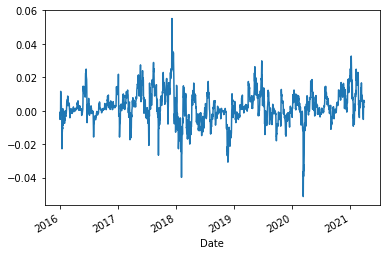

In [91]:
x10.plot()

In [99]:

df["x3"]=x3[1:].values
df["x10"]=x10[1:].values
#df["x30"]=x30[1:].values
df=df[9:]     # model 1 과 동일한 기간으로

In [100]:
df

,state(t),state(t-1),x3,x10
Date,,,,
2016-01-12,0,1,-0.005809,-0.001290
2016-01-13,0,0,-0.006284,-0.002138
2016-01-14,0,0,-0.005900,-0.002477
2016-01-15,0,0,-0.046762,-0.022710
2016-01-16,1,0,-0.019267,-0.012616
...,...,...,...,...
2021-03-28,0,1,0.004397,0.002169
2021-03-28,1,0,0.011211,0.004849
2021-03-29,1,1,0.013412,0.006228


In [101]:
del df["state(t)"]
X=df
y_train=y[0:1450]  ## train set 비율 = 약 76%
y_test=y[1450:]
X_train=X[0:1450]
X_test=X[1450:]

# Tuning Hyper-paramters (n_trees, learning_rate)

In [ ]:
seed=1851   
xNames = np.array(list(X_train))

XX=np.arange(100,1100,100)   ## 10 by 10 grid search
YY=np.arange(0.0001,0.05,0.005)
Z= [ [0] * 10 for _ in range(10) ]

for i in range(10):           
    for j in range(10):  
      params = {'n_estimators': XX[i], 'learning_rate': YY[j]}
      m = ensemble.GradientBoostingClassifier(**params,random_state=seed)
      m.fit(X_train, y_train)
      acc1=round(m.score(X_test, y_test),3)
      Z[i][j]=acc1
      print(i, j, acc1)


# Contour plot (Z=hit rate for y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'color'
  This is separate from the ipykernel package so we can avoid doing imports until


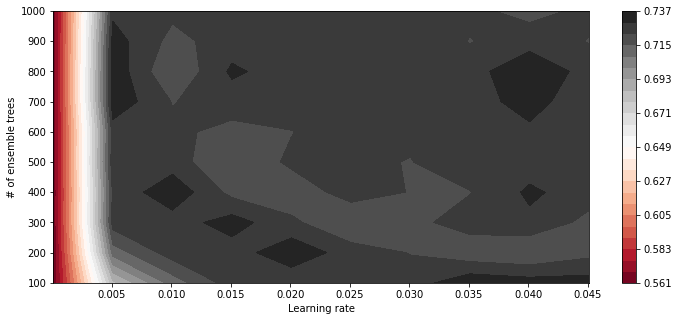

In [108]:
plt.figure(figsize=(12, 5))
cp = plt.contourf(YY, XX, Z, cmap='RdGy',  color='black',
                 levels = np.linspace(np.min(Z), np.max(Z), 25) )
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 12}

plt.colorbar(cp)
plt.xlabel('Learning rate')        
plt.ylabel('# of ensemble trees')   
#plt.savefig('1727.svg')
plt.show()

## Final run with optimaized hyper parameters (n_tree=750, learning rate=0.04)

In [124]:
seed=1851   
xNames = np.array(list(X_train))

params = {'n_estimators': 750,           
          'learning_rate': 0.04}         

m = ensemble.GradientBoostingClassifier(**params,random_state=seed)
m.fit(X_train, y_train)
acc1=round(m.score(X_test, y_test),3)
acc2=round(m.score(X_train, y_train),3)

print('in-sample prediction accuracy=', acc2)
print('out-of-sample prediction accuracy=', acc1)

in-sample prediction accuracy= 0.899
out-of-sample prediction accuracy= 0.728


# BINGO!!

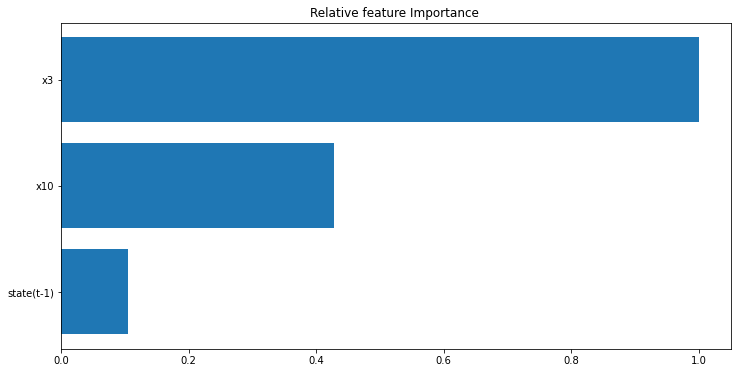

In [116]:
feature_importance = m.feature_importances_/np.max(m.feature_importances_)
#feature_importance = m.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(xNames)[sorted_idx])
plt.title('Relative feature Importance ')

result = permutation_importance(m, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(result.importances[sorted_idx].T,
#            vert=False, labels=np.array(xNames)[sorted_idx])
#plt.title("Permutation Importance (test set)")
#fig.tight_layout()
plt.show()

# Training Fit

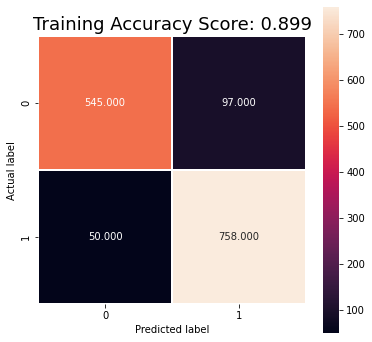

In [117]:
import seaborn as sn 
from sklearn.metrics import accuracy_score, confusion_matrix 

acc=round(m.score(X_train, y_train),3)
con_mat = confusion_matrix(y_true=y_train, y_pred= m.predict(X_train)) 

# confusion matrix heatmap  
plt.figure(figsize=(6,6)) # chart size 
sn.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Training Accuracy Score: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

# Test Fit

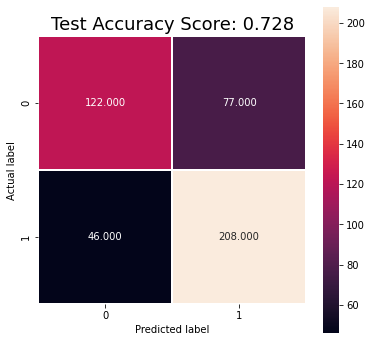

In [118]:
acc=round(m.score(X_test, y_test),3)
con_mat = confusion_matrix(y_true=y_test, y_pred= m.predict(X_test)) 

# confusion matrix heatmap  
plt.figure(figsize=(6,6)) # chart size 
sn.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Test Accuracy Score: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

# 로지스틱 회귀모형보다 훨씬 우수합니다. 

0.5675862068965517
0.565121412803532


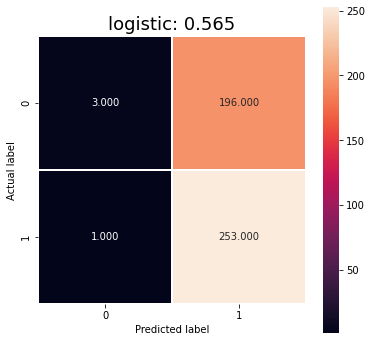

In [119]:
from sklearn.linear_model import LogisticRegression

#print 'Train LogisticRegression()'
clf_init = LogisticRegression();
clf_init.fit(X_train, y_train);
clf_init.fit

print(clf_init.score(X_train, y_train))   ## 로지스틱 리그레션 설명
print(clf_init.score(X_test, y_test))     ## 로지스틱 리그레션 예측
#print 'Train LogisticRegression() is done'
#clf_init.coef_

y_logit=clf_init.predict(X_test)

acc=round(clf_init.score(X_test, y_test), 3)
con_mat = confusion_matrix(y_true=y_test, y_pred= y_logit) 

# 아래를 블럭 실행하기
# confusion matrix heatmap  
plt.figure(figsize=(6,6)) # chart size 
sn.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'logistic: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

# Model 3
-  Hash rate, Gold price, S&P500 등의 변수를 추가하여 보자
-  예상결과: accuracy에 큰 차이가 없다 (아직 안 돌려봄).
- WHY?
- (1) BITcoin 수익률에 이미 반영됨
- (2) Training period인 2019년까지는 Bitcoin과 타 자산가격간의 correlation 이 매우 낮음

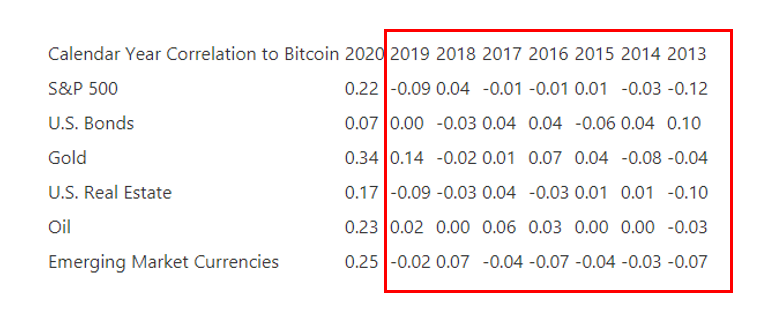

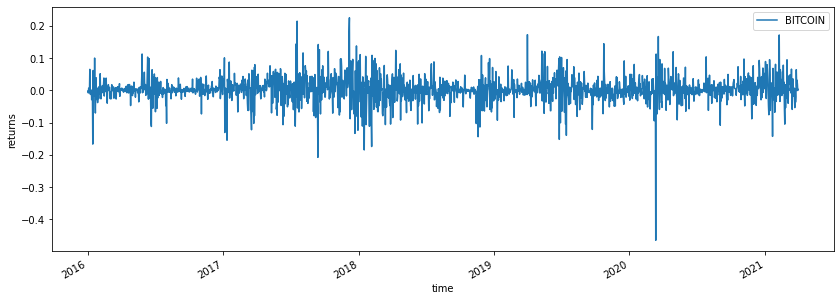

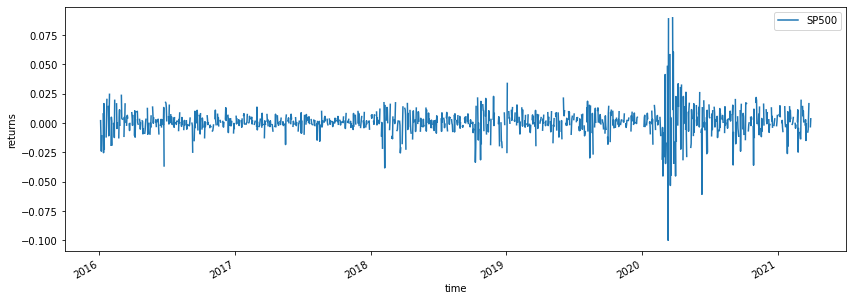

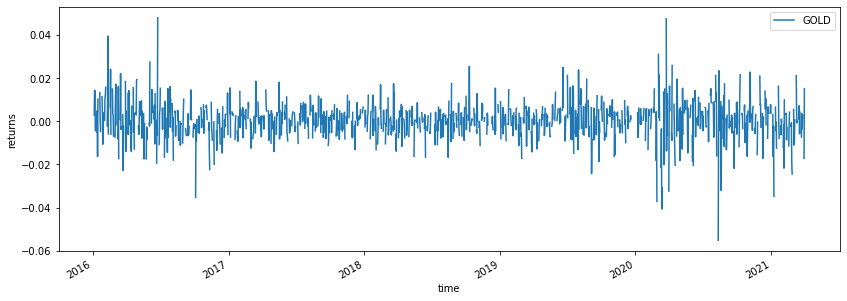

In [126]:
from pandas_datareader import data as wb
import datetime

assets=['BTC-USD', '^GSPC', 'GLD' ]  ## GLD CL.NYM 
data=pd.DataFrame()
for asset in assets:
    data[asset]=wb.DataReader(asset, data_source='yahoo', start='2016-1-1', end='2021-3-31')['Close']


df1 = data
df1["ROR1"] = np.log(df1["BTC-USD"]).diff()
df1["ROR2"] = np.log(df1["^GSPC"]).diff()
df1["ROR3"] = np.log(df1["GLD"]).diff()


#df1 = df1.dropna()
df1.head()

Y1=df1.ROR1
Y2=df1.ROR2
Y3=df1.ROR3

fig, ax = plt.subplots(figsize=(14, 5))
df1.plot(y="ROR1", label='BITCOIN', ax=ax)
ax.set(xlabel='time', ylabel='returns')
ax.legend();

fig, ax = plt.subplots(figsize=(14, 5))
df1.plot(y="ROR2", label='SP500', ax=ax)
ax.set(xlabel='time', ylabel='returns')
ax.legend();

fig, ax = plt.subplots(figsize=(14, 5))
df1.plot(y="ROR3", label='GOLD', ax=ax)
ax.set(xlabel='time', ylabel='returns')
ax.legend();


In [132]:
x3 =Y1.ewm(3).mean()
x10=Y1.ewm(10).mean()
z3=Y2.ewm(3).mean()
z10=Y2.ewm(10).mean()
w3=Y3.ewm(3).mean()
w10=Y3.ewm(10).mean()

X=pd.DataFrame(x3[1:])
X.columns=['bit3']
X['bit10']=x10[1:]
X['sp3']=z3[1:]
X['sp10']=z10[1:]
X['gold3']=w3[1:]
X['gold10']=w10[1:]


y=-1*(Y1<0)+1  ## two states 
y1=-1*(Y2<0)+1
y2=-1*(Y3<0)+1

T=len(Y1)
X['bit(t-1)']=y[0:T-1].values
#X['SP(t-1)']=y1[0:T-1].values
#X['GOLD(t-1)']=y2[0:T-1].values

X['y']=y[1:].values
X=X.dropna()
X=X[7:]
y=X['y']
del X['y']

In [134]:
y

Date
2016-01-12    0
2016-01-13    0
2016-01-14    0
2016-01-15    0
2016-01-16    1
             ..
2021-03-28    0
2021-03-28    1
2021-03-29    1
2021-03-30    1
2021-03-31    1
Name: y, Length: 1903, dtype: int64

In [135]:
y_train=y[0:1450]  ## train set 비율 = 약 76%
y_test=y[1450:]
X_train=X[0:1450]
X_test=X[1450:]

#Friday Effect??
https://www.tandfonline.com/doi/full/10.1080/13504851.2018.1497844?needAccess=true


In [ ]:
seed=1851   
xNames = np.array(list(X_train))

XX=np.arange(100,1100,100)   ## 10 by 10 grid search
YY=np.arange(0.0001,0.05,0.005)
Z= [ [0] * 10 for _ in range(10) ]

for i in range(10):           
    for j in range(10):  
      params = {'n_estimators': XX[i], 'learning_rate': YY[j]}
      m = ensemble.GradientBoostingClassifier(**params,random_state=seed)
      m.fit(X_train, y_train)
      acc1=round(m.score(X_test, y_test),3)
      Z[i][j]=acc1
      print(i, j, acc1)


# Contour plot (Z=hit rate for y_test)

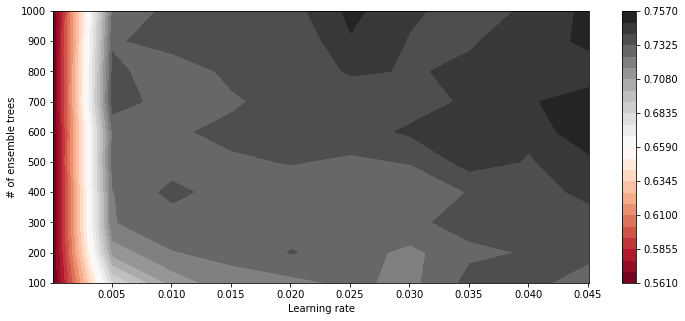

In [137]:
plt.figure(figsize=(12, 5))
cp = plt.contourf(YY, XX, Z, cmap='RdGy',  color='black',
                 levels = np.linspace(np.min(Z), np.max(Z), 25) )
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 12}

plt.colorbar(cp)
plt.xlabel('Learning rate')        
plt.ylabel('# of ensemble trees')   
#plt.savefig('1727.svg')
plt.show()

## Final run with optimaized hyper parameters (n_tree=600, learning rate=0.045)

In [140]:
seed=1851   
xNames = np.array(list(X_train))

params = {'n_estimators': 600,           
          'learning_rate': 0.045}         

m = ensemble.GradientBoostingClassifier(**params,random_state=seed)
m.fit(X_train, y_train)
acc1=round(m.score(X_test, y_test),3)
acc2=round(m.score(X_train, y_train),3)

print('in-sample prediction accuracy=', acc2)
print('out-of-sample prediction accuracy=', acc1)

in-sample prediction accuracy= 0.917
out-of-sample prediction accuracy= 0.742


# improved a liitle

# Test Fit

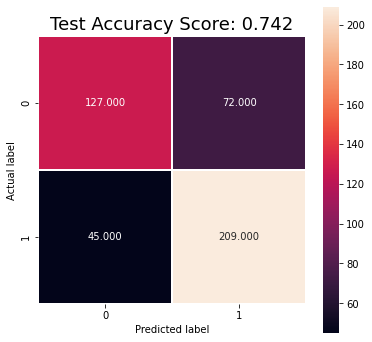

In [146]:
acc=round(m.score(X_test, y_test),3)
con_mat = confusion_matrix(y_true=y_test, y_pred= m.predict(X_test)) 

# confusion matrix heatmap  
plt.figure(figsize=(6,6)) # chart size 
sn.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Test Accuracy Score: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

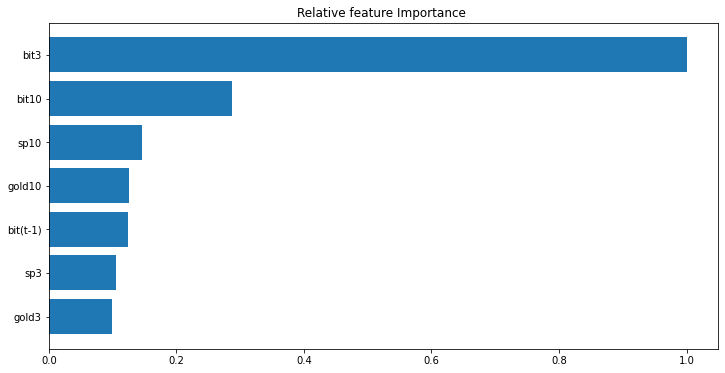

In [141]:
feature_importance = m.feature_importances_/np.max(m.feature_importances_)
#feature_importance = m.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(xNames)[sorted_idx])
plt.title('Relative feature Importance ')

result = permutation_importance(m, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(result.importances[sorted_idx].T,
#            vert=False, labels=np.array(xNames)[sorted_idx])
#plt.title("Permutation Importance (test set)")
#fig.tight_layout()
plt.show()

# Logistic Regression과 비교

0.5675862068965517
0.565121412803532


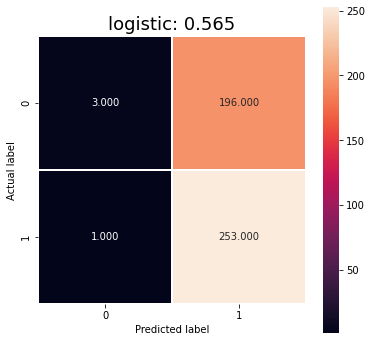

In [145]:
from sklearn.linear_model import LogisticRegression

#print 'Train LogisticRegression()'
clf_init = LogisticRegression();
clf_init.fit(X_train, y_train);
clf_init.fit

print(clf_init.score(X_train, y_train))   ## 로지스틱 리그레션 설명
print(clf_init.score(X_test, y_test))     ## 로지스틱 리그레션 예측
#print 'Train LogisticRegression() is done'
#clf_init.coef_

y_logit=clf_init.predict(X_test)

acc=round(clf_init.score(X_test, y_test), 3)
con_mat = confusion_matrix(y_true=y_test, y_pred= y_logit) 

# 아래를 블럭 실행하기
# confusion matrix heatmap  
plt.figure(figsize=(6,6)) # chart size 
sn.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'logistic: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

# Visualizing Covariate Effects by PDP
# 이 결과를 잘 해석하는 것이 필요합니다.

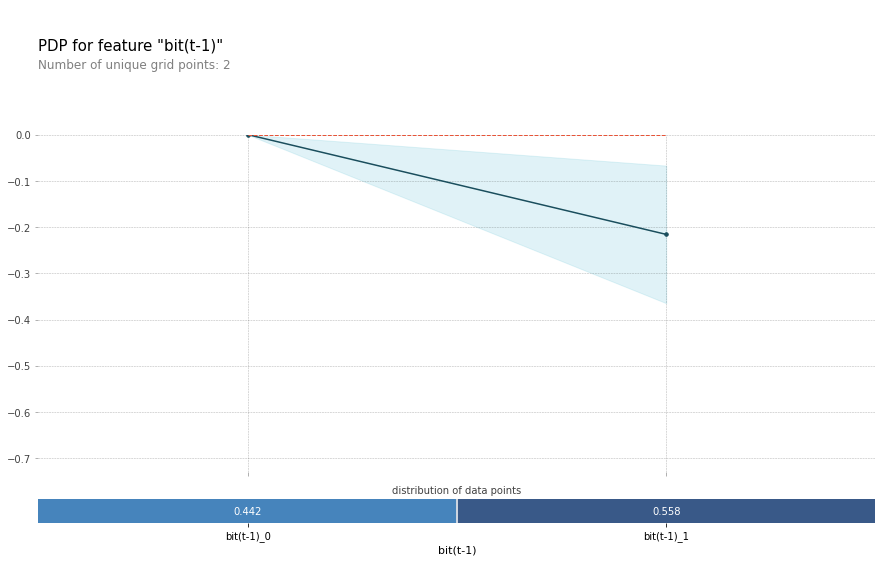

In [144]:
from pdpbox import pdp, info_plots
k=xNames[6]
pdp_1 = pdp.pdp_isolate(model=m, dataset=X, model_features=list(X), feature=k)
#PDP Plot0
fig, axes = pdp.pdp_plot(pdp_1, k, plot_lines=False, center=True, frac_to_plot=0.5, plot_pts_dist=True,x_quantile=False, show_percentile=True)
#ICE Plot
#fig, axes = pdp.pdp_plot(pdp_1, k, plot_lines=True, center=True, frac_to_plot=1, plot_pts_dist=True,x_quantile=True, show_percentile=True)


# Interaction Effect

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe790a29710>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe78bd386d0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


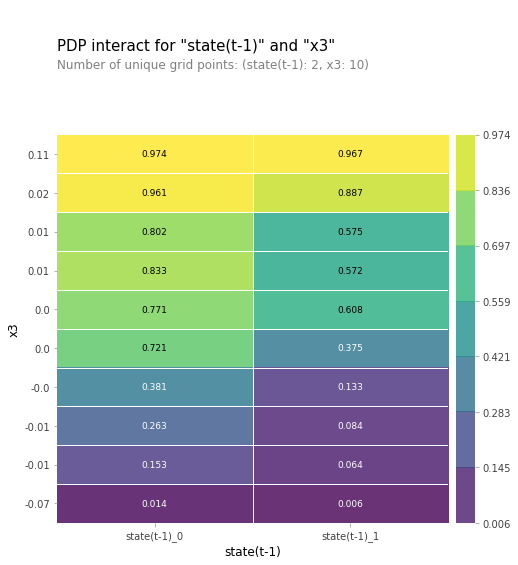

In [123]:
k1=xNames[0]
k2=xNames[1]

# Two variable interaction plot
inter= pdp.pdp_interact(model=m, dataset=X_train, model_features=X_train.columns,
                             features=[k1,k2])
pdp.pdp_interact_plot(inter, [k1,k2], x_quantile=False, plot_type='grid', plot_pdp=False) 